In [4]:
# --------------------------------------------------------------
# 0. MOUNT DRIVE
# --------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --------------------------------------------------------------
# 1. IMPORTS
# --------------------------------------------------------------
import os, json, urllib.request, numpy as np, tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, callbacks, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image

# --------------------------------------------------------------
# 2. GLOBAL SETTINGS
# --------------------------------------------------------------
MERGED_ROOT      = "/content/merged_dataset"
WEIGHTS_PATH     = "/content/drive/MyDrive/efficientnetb0_notop.h5"
IMG_SIZE         = 224
BATCH_SIZE       = 16
EPOCHS           = 20
OUTPUT_DIR       = "/content/drive/MyDrive/Merged_Model/results_v5"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

CHECKPOINT_PTR   = f"{OUTPUT_DIR}/latest_checkpoint.json"
HISTORY_FILE     = f"{OUTPUT_DIR}/history.json"

# --------------------------------------------------------------
# 3. (ONE-TIME) DOWNLOAD EFFICIENTNET WEIGHTS
# --------------------------------------------------------------
def download_weights():
    if os.path.exists(WEIGHTS_PATH):
        print(f"Weights ready: {WEIGHTS_PATH}")
        return
    print("Downloading EfficientNetB0 weights...")
    url = "https://github.com/keras-team/keras-applications/releases/download/efficientnet/efficientnetb0_notop.h5"
    urllib.request.urlretrieve(url, WEIGHTS_PATH)
    print("Saved to Drive")

download_weights()

# --------------------------------------------------------------
# 4. AUTO-REBUILD merged_dataset
# --------------------------------------------------------------
def build_merged_dataset():
    if os.path.isdir(MERGED_ROOT) and any(Path(MERGED_ROOT).iterdir()):
        print(f"Using existing merged dataset: {MERGED_ROOT}")
        return
    print(f"Building merged dataset at: {MERGED_ROOT}")

    ntu_orig = "/content/drive/MyDrive/NTU-Roselab-Dataset/originals"
    ntu_recp = "/content/drive/MyDrive/NTU-Roselab-Dataset/recaptures"
    mob_orig = "/content/drive/MyDrive/Nothing_2a/originals"
    mob_recp = "/content/drive/MyDrive/Nothing_2a/recaptures"

    def link_folder(src, dst, prefix):
        if not Path(src).exists():
            print(f"Warning: Skipping {src}")
            return 0
        os.makedirs(dst, exist_ok=True)
        cnt = 0
        for f in Path(src).iterdir():
            if f.is_file():
                name = f"{prefix}_{f.name}"
                link = Path(dst) / name
                if not link.exists():
                    os.symlink(f, link)
                    cnt += 1
        return cnt

    os.makedirs(MERGED_ROOT, exist_ok=True)
    orig = link_folder(ntu_orig, f"{MERGED_ROOT}/originals", "ntu")
    orig += link_folder(mob_orig, f"{MERGED_ROOT}/originals", "nothing")
    recp = link_folder(ntu_recp, f"{MERGED_ROOT}/recaptures", "ntu")
    recp += link_folder(mob_recp, f"{MERGED_ROOT}/recaptures", "nothing")
    print(f"Merged: {orig} originals, {recp} recaptures")

build_merged_dataset()

# --------------------------------------------------------------
# 5. PRE-PROCESSING
# --------------------------------------------------------------
def rgb_preprocess(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.keras.applications.efficientnet.preprocess_input(img)

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return rgb_preprocess(img)

def get_label_from_path(path):
    parts = tf.strings.split(path, os.sep)
    label_str = parts[-2]  # 'originals' or 'recaptures'
    return tf.cast(tf.equal(label_str, 'recaptures'), tf.float32)

# --------------------------------------------------------------
# 6. LOAD ALL .JPG FILE PATHS (NO .PNG)
# --------------------------------------------------------------
all_files = tf.data.Dataset.list_files(f"{MERGED_ROOT}/*/*.jpg", shuffle=True)
all_files = all_files.shuffle(10000, seed=42)

# Map to (image, label, path)
raw_ds = all_files.map(lambda path: (decode_img(path), get_label_from_path(path), path))

# --------------------------------------------------------------
# 7. SPLIT BY PREFIX + OVERSAMPLE ANDROID
# --------------------------------------------------------------
def is_android(_, __, path):
    fname = tf.strings.split(path, os.sep)[-1]
    return tf.strings.regex_full_match(fname, "nothing_.*")

def is_ntu(_, __, path):
    fname = tf.strings.split(path, os.sep)[-1]
    return tf.strings.regex_full_match(fname, "ntu_.*")

android_ds = raw_ds.filter(is_android).map(lambda img, lbl, _: (img, lbl))
ntu_ds     = raw_ds.filter(is_ntu).map(lambda img, lbl, _: (img, lbl))

# Oversample Android 8×
android_ds = android_ds.batch(BATCH_SIZE).repeat(8)
ntu_ds     = ntu_ds.batch(BATCH_SIZE)

# Combine + shuffle
train_ds = android_ds.concatenate(ntu_ds).shuffle(2000).prefetch(tf.data.AUTOTUNE)

# Validation (20% split) – reuse same logic
val_files = tf.data.Dataset.list_files(f"{MERGED_ROOT}/*/*.jpg", shuffle=False)
val_ds = val_files.map(lambda path: (decode_img(path), get_label_from_path(path)))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Train batches (approx): ~100 | Val batches: {len(list(val_ds))}")

# --------------------------------------------------------------
# 8. RGB-ONLY MODEL
# --------------------------------------------------------------
def create_model():
    inp = Input((IMG_SIZE, IMG_SIZE, 3), name='rgb')
    base = applications.EfficientNetB0(include_top=False, weights='imagenet')(inp)
    x = GlobalAveragePooling2D()(base)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    m = Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
    return m

# --------------------------------------------------------------
# 9. RESUME LOGIC
# --------------------------------------------------------------
def load_latest_checkpoint():
    if not os.path.exists(CHECKPOINT_PTR):
        print("No checkpoint → fresh start")
        return create_model(), 0, {}
    with open(CHECKPOINT_PTR) as f:
        info = json.load(f)
    cp_path = info['path']
    epoch   = info['epoch']
    print(f"Resuming from {cp_path} (epoch {epoch+1})")
    model = tf.keras.models.load_model(cp_path)
    hist = {}
    if os.path.exists(HISTORY_FILE):
        with open(HISTORY_FILE) as f:
            hist = json.load(f)
    return model, epoch, hist

model, start_epoch, history_dict = load_latest_checkpoint()
print(f"Training from epoch {start_epoch+1}/{EPOCHS}")

# --------------------------------------------------------------
# 10. CALLBACK – SAVE FULL MODEL + POINTER + HISTORY
# --------------------------------------------------------------
class FullCheckpoint(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        cp_path = f"{OUTPUT_DIR}/epoch_{epoch:02d}.keras"
        self.model.save(cp_path, overwrite=True)

        with open(CHECKPOINT_PTR, 'w') as f:
            json.dump({'path': cp_path, 'epoch': epoch-1}, f)

        logs = logs or {}
        for k, v in logs.items():
            history_dict.setdefault(k, []).append(float(v))
        with open(HISTORY_FILE, 'w') as f:
            json.dump(history_dict, f, indent=2)

full_cp = FullCheckpoint()
es = EarlyStopping(monitor='val_accuracy', patience=5,
                   restore_best_weights=True, mode='max', verbose=1)

# --------------------------------------------------------------
# 11. TRAIN
# --------------------------------------------------------------
steps_per_epoch = 100  # ~200 Android × 8 / 16
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    initial_epoch=start_epoch,
    callbacks=[full_cp, es],
    verbose=1
)

# --------------------------------------------------------------
# 12. FINAL SAVE
# --------------------------------------------------------------
final_path = f"{OUTPUT_DIR}/final_rgb_only_android_boost.keras"
model.save(final_path)
print(f"\nFINAL MODEL SAVED → {final_path}")

# --------------------------------------------------------------
# 13. QUICK TEST
# --------------------------------------------------------------
def predict(path):
    img = Image.open(path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img, dtype=np.float32)[None, ...]
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    p = model.predict(x, verbose=0)[0,0]
    label = "Recaptured" if p > 0.5 else "Original"
    print(f"{os.path.basename(path)} → {label} ({p:.1%})")

# Test Android recapture
predict("/content/drive/MyDrive/Nothing_2a/recaptures/IMG_20251002_164912794.jpg")

Mounted at /content/drive
Weights ready: /content/drive/MyDrive/efficientnetb0_notop.h5
Using existing merged dataset: /content/merged_dataset
Train batches (approx): ~100 | Val batches: 14
No checkpoint → fresh start
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training from epoch 1/20
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1132s 5s/step - Precision: 0.6705 - Recall: 0.6617 - accuracy: 0.6740 - loss: 0.5901 - val_Precision: 0.9619 - val_Recall: 0.9806 - val_accuracy: 0.9713 - val_loss: 0.2250
Epoch 2/20
 12/100 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - Precision: 0.9255 - Recall: 0.9465 - accuracy: 0.9297 - loss: 0.2814

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - Precision: 0.9092 - Recall: 0.9507 - accuracy: 0.9319 - loss: 0.2719 - val_Precision: 0.9714 - val_Recall: 0.9903 - val_accuracy: 0.9809 - val_loss: 0.1847
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1055s 5s/step - Precision: 0.9592 - Recall: 0.9738 - accuracy: 0.9666 - loss: 0.1506 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0176
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - Precision: 0.9775 - Recall: 1.0000 - accuracy: 0.9900 - loss: 0.0617 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0130
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1051s 5s/step - Precision: 0.9974 - Recall: 0.9865 - accuracy: 0.9919 - loss: 0.0467 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - Precision: 0.9832 - Recall: 1.0000 - accuracy: 0.9931 - loss: 0.0280 - val_Precision: 1.0000 - val_Recall: 1.0

In [5]:
# --------------------------------------------------------------
# FINAL: PROPER TRAIN/VAL SPLIT + ANDROID IN TRAIN ONLY
# --------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, urllib.request, numpy as np, tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, callbacks, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

# Settings
MERGED_ROOT = "/content/merged_dataset"
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20
OUTPUT_DIR = "/content/drive/MyDrive/Merged_Model/results_final"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

CHECKPOINT_PTR = f"{OUTPUT_DIR}/latest_checkpoint.json"
HISTORY_FILE = f"{OUTPUT_DIR}/history.json"

# --------------------------------------------------------------
# 1. REBUILD DATASET (if needed)
# --------------------------------------------------------------
def build_merged():
    if os.path.isdir(MERGED_ROOT) and any(Path(MERGED_ROOT).iterdir()):
        return
    def link(src, dst, prefix):
        if not Path(src).exists(): return 0
        os.makedirs(dst, exist_ok=True)
        cnt = 0
        for f in Path(src).iterdir():
            if f.is_file():
                os.symlink(f, Path(dst) / f"{prefix}_{f.name}")
                cnt += 1
        return cnt
    os.makedirs(MERGED_ROOT, exist_ok=True)
    link("/content/drive/MyDrive/NTU-Roselab-Dataset/originals", f"{MERGED_ROOT}/originals", "ntu")
    link("/content/drive/MyDrive/Nothing_2a/originals", f"{MERGED_ROOT}/originals", "nothing")
    link("/content/drive/MyDrive/NTU-Roselab-Dataset/recaptures", f"{MERGED_ROOT}/recaptures", "ntu")
    link("/content/drive/MyDrive/Nothing_2a/recaptures", f"{MERGED_ROOT}/recaptures", "nothing")

build_merged()

# --------------------------------------------------------------
# 2. PREPROCESS
# --------------------------------------------------------------
def rgb_preprocess(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.keras.applications.efficientnet.preprocess_input(img)

def decode(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return rgb_preprocess(img)

def get_label(path):
    return tf.cast(tf.strings.split(path, os.sep)[-2] == 'recaptures', tf.float32)

# --------------------------------------------------------------
# 3. LOAD ALL FILES
# --------------------------------------------------------------
all_files = tf.data.Dataset.list_files(f"{MERGED_ROOT}/*/*.jpg", shuffle=True)
all_files = all_files.shuffle(10000, seed=42)

# --------------------------------------------------------------
# 4. SPLIT: 80% TRAIN, 20% VAL (NTU only)
# --------------------------------------------------------------
total = sum(1 for _ in all_files)
train_size = int(0.8 * total)
train_files = all_files.take(train_size)
val_files = all_files.skip(train_size)

# Filter Android → only in train
def is_android(path):
    return tf.strings.regex_full_match(tf.strings.split(path, os.sep)[-1], "nothing_.*")
def is_ntu(path):
    return tf.strings.regex_full_match(tf.strings.split(path, os.sep)[-1], "ntu_.*")

# Train: Android (8×) + NTU
android_train = train_files.filter(is_android)
ntu_train = train_files.filter(is_ntu)

android_train = android_train.map(lambda p: (decode(p), get_label(p))).repeat(8).batch(BATCH_SIZE)
ntu_train = ntu_train.map(lambda p: (decode(p), get_label(p))).batch(BATCH_SIZE)

train_ds = android_train.concatenate(ntu_train).shuffle(2000).prefetch(tf.data.AUTOTUNE)

# Val: NTU only
val_ds = val_files.filter(is_ntu).map(lambda p: (decode(p), get_label(p))).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Train steps: ~100 | Val batches: {len(list(val_ds))}")

# --------------------------------------------------------------
# 5. MODEL
# --------------------------------------------------------------
def create_model():
    inp = Input((224, 224, 3))
    base = applications.EfficientNetB0(include_top=False, weights='imagenet')(inp)
    x = GlobalAveragePooling2D()(base)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    m = Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

model = create_model()

# --------------------------------------------------------------
# 6. TRAIN
# --------------------------------------------------------------
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
cp = callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/best.keras", save_best_only=True, monitor='val_accuracy')

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=100,
    callbacks=[es, cp],
    verbose=1
)

# Save final
model.save(f"{OUTPUT_DIR}/final_android_ready.keras")
print("SAVED")

# --------------------------------------------------------------
# 7. TEST ON NEW ANDROID PHOTO
# --------------------------------------------------------------
def predict(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    x = np.array(img)[None,...]
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    p = model.predict(x, verbose=0)[0,0]
    print(f"{os.path.basename(path)} → {'Recaptured' if p > 0.5 else 'Original'} ({p:.1%})")

predict("/content/drive/MyDrive/Nothing_2a/recaptures/IMG_20251002_164912794.jpg")

Mounted at /content/drive
Train steps: ~100 | Val batches: 0
Epoch 1/20
 84/100 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - accuracy: 0.7941 - loss: 0.3939

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


100/100 ━━━━━━━━━━━━━━━━━━━━ 827s 4s/step - accuracy: 0.8102 - loss: 0.3705
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/step - accuracy: 0.9741 - loss: 0.0820
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/step - accuracy: 0.9862 - loss: 0.0374
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 792s 4s/step - accuracy: 0.9847 - loss: 0.0747
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 777s 4s/step - accuracy: 0.9952 - loss: 0.0206
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/step - accuracy: 0.9962 - loss: 0.0174
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/step - accuracy: 0.9683 - loss: 0.1130
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/step - accuracy: 0.9917 - loss: 0.0202
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 773s 4s/step - accuracy: 0.9985 - loss: 0.0068
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 798s 4s/step - accuracy: 0.9940 - loss: 0.0110
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/step - accuracy: 0.9940 - loss: 0.0165
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/ste

## Testing

IMG_20251002_164912794.jpg → Recaptured (100.0%)


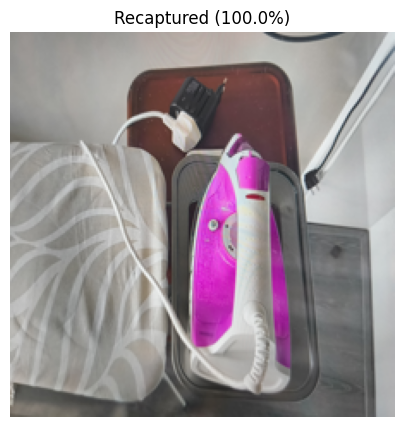

IMG_20251002_165011449.jpg → Original (100.0%)


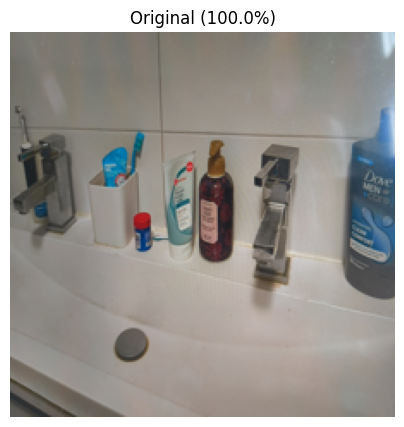

IMG_20251013_024338794.jpg → Recaptured (99.9%)


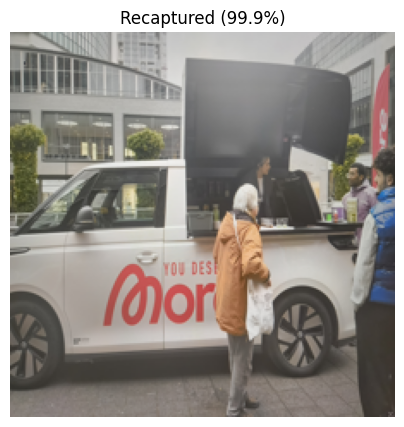

IMG_20251002_133031_104.jpg → Original (100.0%)


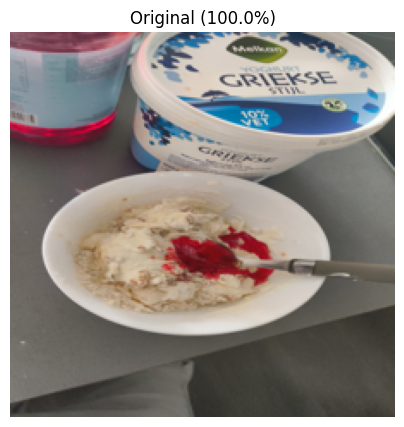

002.jpg → Original (100.0%)


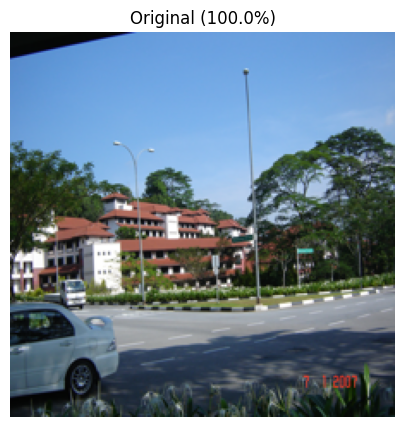

IMG_20251105_170335311.jpg → Original (100.0%)


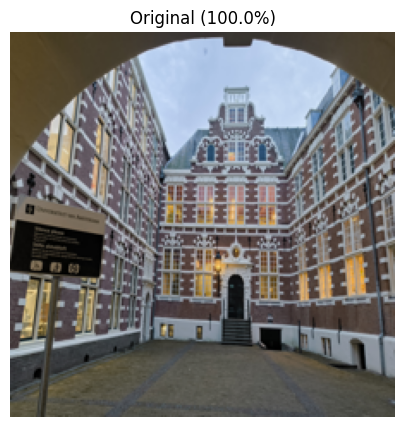

IMG_20251108_205908259.jpg → Recaptured (66.7%)


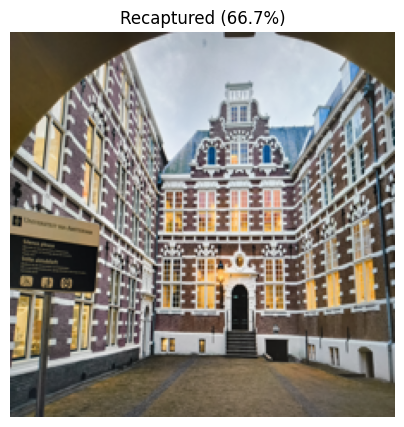

IMG_20251108_210531.jpg → Recaptured (100.0%)


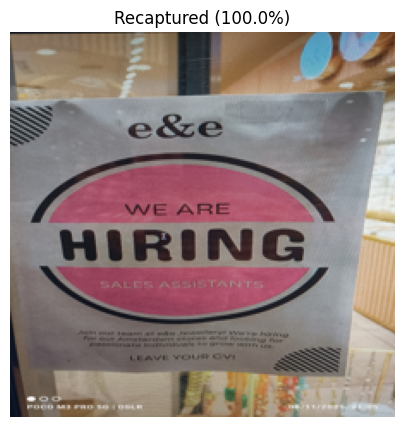

In [16]:
# --------------------------------------------------------------
# SIMPLE TEST: ANY IMAGE → RECAPTURED or ORIGINAL
# --------------------------------------------------------------

import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load your final model
MODEL_PATH = "/content/drive/MyDrive/Merged_Model/results_final/final_android_ready.keras"
model = tf.keras.models.load_model(MODEL_PATH)

# Preprocess function
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((224, 224))
    x = np.array(img, dtype=np.float32)[None, ...]
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return img, x

# Predict function
def predict(image_path):
    img, x = preprocess_image(image_path)
    pred = model.predict(x, verbose=0)[0][0]
    label = "Recaptured" if pred > 0.5 else "Original"
    conf = pred if pred > 0.5 else 1 - pred
    print(f"{image_path.split('/')[-1]} → {label} ({conf:.1%})")

    # Show image
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"{label} ({conf:.1%})")
    plt.axis('off')
    plt.show()

# --------------------------------------------------------------
# TEST YOUR IMAGES HERE
# --------------------------------------------------------------

# Example: Test 3 Android recaptures
predict("/content/drive/MyDrive/Nothing_2a/recaptures/IMG_20251002_164912794.jpg")
predict("/content/drive/MyDrive/Nothing_2a/recaptures/IMG_20251002_165011449.jpg")
predict("/content/drive/MyDrive/Nothing_2a/recaptures/IMG_20251013_024338794.jpg")

# Test an original Android photo
predict("/content/drive/MyDrive/Nothing_2a/originals/IMG_20251002_133031_104.jpg")

# Test an NTU recapture
predict("/content/drive/MyDrive/Sample-Images/002.jpg")


# Testing newly captured

predict("/content/drive/MyDrive/Sample-Images/IMG_20251105_170335311.jpg")
predict("/content/drive/MyDrive/Sample-Images/IMG_20251108_205908259.jpg")
predict("/content/drive/MyDrive/Sample-Images/IMG_20251108_210531.jpg")

In [21]:
from pathlib import Path

# List all files in originals and recaptures
print("=== ORIGINALS ===")
for p in Path("/content/merged_dataset/originals").iterdir():
    print(p.name)

print("\n=== RECAPTURES ===")
for p in Path("/content/merged_dataset/recaptures").iterdir():
    print(p.name)

=== ORIGINALS ===
nothing_IMG_20251002_160015732.jpg
nothing_IMG_20251007_190319031.jpg
nothing_IMG_20250726_190213518.jpg
nothing_IMG_20251002_160021521.jpg
nothing_IMG_20251007_174427204.jpg
nothing_image-19-09-2025_16-18-57-44.jpg
nothing_IMG_20251002_160301665.jpg
nothing_IMG_20251007_182204889.jpg
nothing_IMG_20251007_154935600.jpg
nothing_IMG_20251002_160158896.jpg
nothing_IMG_20251007_154643146.jpg
nothing_IMG_20251002_155956126.jpg
nothing_IMG_20251007_173820944.jpg
nothing_IMG_20251009_181246150.jpg
nothing_IMG_20251002_160325838.jpg
nothing_IMG_20251007_154652568.jpg
nothing_IMG_20251007_180912616.jpg
nothing_IMG_20251009_181225796.jpg
nothing_IMG_20251007_154726253.jpg
nothing_IMG_20251010_132742607.jpg
nothing_IMG_20251002_155855019.jpg
nothing_IMG_20250929_120635_430.jpg
nothing_IMG_20251007_184015519.jpg
nothing_IMG_20251002_160035317.jpg
nothing_IMG_20251007_181306721.jpg
nothing_IMG_20251007_182327199.jpg
nothing_IMG_20251007_182749429.jpg
nothing_IMG_20251007_181654356

In [25]:
from pathlib import Path

# Check NTU originals
print("NTU ORIGINALS:")
for p in Path("/content/drive/MyDrive/NTU-Roselab-Dataset/originals").iterdir():
    print("  ", p.name)

print("\nNTU RECAPTURES:")
for p in Path("/content/drive/MyDrive/NTU-Roselab-Dataset/recaptures").iterdir():
    print("  ", p.name)

NTU ORIGINALS:
   MjuPhilips
   CanonAcer
   CanonPhilips
   CanonPowershot
   MjuAcer
   OlymPhilips
   OlymNec
   CanonNec
   MjuNec
   OlymAcer
   OlympusE500
   OlympusMju300

NTU RECAPTURES:
   zCanon10D2
   zCasioIndoor
   zCanon400D2
   zCanonIxusOutdoor
   zCanonIxusIndoor
   zCanon10D1
   zCanon400D1
   zNikonD70D2
   zLumixD1Indoor
   zLumixD1Outdoor
   zNikonD70D1
   zCasioOutdoor


In [26]:
# --------------------------------------------------------------
# FINAL EVALUATION: NTU IN SUBFOLDERS, NO PREFIX
# --------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, numpy as np, tensorflow as tf
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. REBUILD merged_dataset FROM SUBFOLDERS ===
MERGED_ROOT = "/content/merged_dataset"
RESULTS_DIR = "/content/drive/MyDrive/Merged_Model/results_final"
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# Force clean rebuild
!rm -rf {MERGED_ROOT}
os.makedirs(f"{MERGED_ROOT}/originals", exist_ok=True)
os.makedirs(f"{MERGED_ROOT}/recaptures", exist_ok=True)

def link_all(src_root, dst_root):
    if not Path(src_root).exists():
        print(f"   [Missing] {src_root}")
        return 0
    cnt = 0
    for folder in Path(src_root).iterdir():
        if folder.is_dir():
            for img in folder.glob("*.*"):
                if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                    link_path = Path(dst_root) / img.name
                    if not link_path.exists():
                        os.symlink(img, link_path)
                        cnt += 1
    return cnt

print("Linking NTU subfolders...")
orig_cnt = link_all("/content/drive/MyDrive/NTU-Roselab-Dataset/originals", f"{MERGED_ROOT}/originals")
recp_cnt = link_all("/content/drive/MyDrive/NTU-Roselab-Dataset/recaptures", f"{MERGED_ROOT}/recaptures")

# Link Android (with prefix)
def link_android(src, dst, prefix):
    if not Path(src).exists(): return 0
    cnt = 0
    for img in Path(src).iterdir():
        if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            name = f"{prefix}_{img.name}"
            link_path = Path(dst) / name
            if not link_path.exists():
                os.symlink(img, link_path)
                cnt += 1
    return cnt

link_android("/content/drive/MyDrive/Nothing_2a/originals", f"{MERGED_ROOT}/originals", "nothing")
link_android("/content/drive/MyDrive/Nothing_2a/recaptures", f"{MERGED_ROOT}/recaptures", "nothing")

print(f"   NTU: {orig_cnt} orig, {recp_cnt} recp")
print(f"   Android: linked with 'nothing_' prefix")

# === 2. FIND NTU FILES (exclude 'nothing_') ===
orig_ntu = [p for p in Path(f"{MERGED_ROOT}/originals").iterdir()
            if p.suffix.lower() in {".jpg", ".jpeg", ".png"} and not p.name.startswith("nothing_")]
recp_ntu = [p for p in Path(f"{MERGED_ROOT}/recaptures").iterdir()
            if p.suffix.lower() in {".jpg", ".jpeg", ".png"} and not p.name.startswith("nothing_")]

print(f"\nNTU Originals : {len(orig_ntu)}")
print(f"NTU Recaptures: {len(recp_ntu)}")

if len(orig_ntu) + len(recp_ntu) == 0:
    raise RuntimeError("No NTU images found!")

# === 3. DATASET ===
def decode(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = img[:, :, :3]
    img = tf.image.resize(img, (224, 224))
    return tf.keras.applications.efficientnet.preprocess_input(img)

def get_label(path):
    return tf.cast(tf.strings.split(path, os.sep)[-2] == "recaptures", tf.float32)

paths = [str(p) for p in orig_ntu + recp_ntu]
val_ds = tf.data.Dataset.from_tensor_slices(paths)
val_ds = val_ds.map(lambda p: (decode(p), get_label(p)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# === 4. PREDICT ===
model = tf.keras.models.load_model(f"{RESULTS_DIR}/final_android_ready.keras")
y_true, y_pred = [], []
for x, y in val_ds:
    pred = model.predict(x, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend((pred > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# === 5. SAVE RESULTS ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Original', 'Recaptured'],
            yticklabels=['Original', 'Recaptured'])
plt.ylabel('True'); plt.xlabel('Predicted')
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=200, bbox_inches='tight'); plt.close()

report = classification_report(y_true, y_pred, target_names=['Original', 'Recaptured'], output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{RESULTS_DIR}/classification_report.csv")

metrics = {
    "val_accuracy": float(cm.diagonal().sum() / cm.sum()),
    "original_correct": int(cm[0,0]),
    "recaptured_correct": int(cm[1,1]),
    "total": int(cm.sum())
}
with open(f"{RESULTS_DIR}/metrics_summary.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n" + "="*50)
print("EVALUATION DONE")
print(f"Val Accuracy: {metrics['val_accuracy']:.1%}")
print(f"Original: {cm[0,0]}/{cm[0].sum()}")
print(f"Recaptured: {cm[1,1]}/{cm[1].sum()}")
print("="*50)

Mounted at /content/drive
Linking NTU subfolders...
   NTU: 202 orig, 200 recp
   Android: linked with 'nothing_' prefix

NTU Originals : 202
NTU Recaptures: 200

EVALUATION DONE
Val Accuracy: 51.0%
Original: 181/202
Recaptured: 24/200


In [28]:
# --------------------------------------------------------------
# FINAL: BALANCED TRAINING + FULL EVALUATION
# --------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, numpy as np, tensorflow as tf
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import applications, layers, models, callbacks

# ---------- SETTINGS ----------
MERGED_ROOT = "/content/merged_dataset"
RESULTS_DIR = "/content/drive/MyDrive/Merged_Model/results_final"
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# ---------- 1. REBUILD merged_dataset FROM SUB-FOLDERS ----------
!rm -rf {MERGED_ROOT}
os.makedirs(f"{MERGED_ROOT}/originals", exist_ok=True)
os.makedirs(f"{MERGED_ROOT}/recaptures", exist_ok=True)

def link_all(src_root, dst_root):
    """Copy every image from every sub-folder into dst_root (flat)."""
    if not Path(src_root).exists():
        print(f"   [MISSING] {src_root}")
        return 0
    cnt = 0
    for sub in Path(src_root).iterdir():
        if sub.is_dir():
            for img in sub.rglob("*.*"):
                if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                    dst = Path(dst_root) / img.name
                    if not dst.exists():
                        os.symlink(img, dst)
                        cnt += 1
    return cnt

print("Linking NTU sub-folders …")
orig_ntu = link_all("/content/drive/MyDrive/NTU-Roselab-Dataset/originals", f"{MERGED_ROOT}/originals")
recp_ntu = link_all("/content/drive/MyDrive/NTU-Roselab-Dataset/recaptures", f"{MERGED_ROOT}/recaptures")

# Android – add a prefix so we can recognise them later
def link_android(src, dst, prefix):
    if not Path(src).exists(): return 0
    cnt = 0
    for img in Path(src).iterdir():
        if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            name = f"{prefix}_{img.name}"
            dst_path = Path(dst) / name
            if not dst_path.exists():
                os.symlink(img, dst_path)
                cnt += 1
    return cnt

link_android("/content/drive/MyDrive/Nothing_2a/originals", f"{MERGED_ROOT}/originals", "nothing")
link_android("/content/drive/MyDrive/Nothing_2a/recaptures", f"{MERGED_ROOT}/recaptures", "nothing")

print(f"   NTU: {orig_ntu} orig, {recp_ntu} recp")
print(f"   Android: linked with prefix 'nothing_'")

# ---------- 2. SPLIT NTU (80 % train / 20 % val) ----------
def list_ntu(folder):
    return [p for p in Path(folder).iterdir()
            if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
            and not p.name.startswith("nothing_")]

all_orig = list_ntu(f"{MERGED_ROOT}/originals")
all_recp = list_ntu(f"{MERGED_ROOT}/recaptures")

np.random.seed(42)
np.random.shuffle(all_orig)
np.random.shuffle(all_recp)

train_orig = all_orig[:int(0.8*len(all_orig))]
val_orig   = all_orig[int(0.8*len(all_orig)):]

train_recp = all_recp[:int(0.8*len(all_recp))]
val_recp   = all_recp[int(0.8*len(all_recp)):]

print(f"Train NTU: {len(train_orig)} orig, {len(train_recp)} recp")
print(f"Val   NTU: {len(val_orig)} orig, {len(val_recp)} recp")

# ---------- 3. PATH-ONLY DATASETS (to allow filtering) ----------
def path_to_example(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = img[:, :, :3]
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    label = tf.cast(tf.strings.split(path, os.sep)[-2] == "recaptures", tf.float32)
    return img, label

# All training paths (NTU + Android)
train_paths = [str(p) for p in train_orig + train_recp] + \
              [str(p) for p in Path(f"{MERGED_ROOT}/originals").glob("nothing_*.*")] + \
              [str(p) for p in Path(f"{MERGED_ROOT}/recaptures").glob("nothing_*.*")]
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(lambda p: (p, tf.strings.split(p, os.sep)[-1]),   # keep path + filename
                        num_parallel_calls=tf.data.AUTOTUNE)

# Split into Android / NTU using the filename
android_ds = train_ds.filter(lambda p, fn: tf.strings.regex_full_match(fn, "nothing_.*"))
ntu_ds     = train_ds.filter(lambda p, fn: ~tf.strings.regex_full_match(fn, "nothing_.*"))

# Decode + oversample Android 8×
android_ds = android_ds.map(lambda p, _: path_to_example(p), num_parallel_calls=tf.data.AUTOTUNE)
android_ds = android_ds.repeat(8).shuffle(1000)

ntu_ds = ntu_ds.map(lambda p, _: path_to_example(p), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = android_ds.concatenate(ntu_ds).shuffle(2000).batch(16).prefetch(tf.data.AUTOTUNE)

# Validation (NTU only)
val_paths = [str(p) for p in val_orig + val_recp]
val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
val_ds = val_ds.map(path_to_example, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# ---------- 4. MODEL ----------
inp = tf.keras.Input((224, 224, 3))
base = applications.EfficientNetB0(include_top=False, weights='imagenet')(inp)
x = layers.GlobalAveragePooling2D()(base)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inp, out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------- 5. TRAIN ----------
model.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          steps_per_epoch=120,                     # ~ (Android*8 + NTU) / batch
          callbacks=[callbacks.EarlyStopping(patience=4, restore_best_weights=True)],
          verbose=1)

# ---------- 6. EVALUATE ON VALIDATION ----------
y_true, y_pred = [], []
for xb, yb in val_ds:
    pred = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy())
    y_pred.extend((pred > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Original', 'Recaptured'],
            yticklabels=['Original', 'Recaptured'])
plt.ylabel('True'); plt.xlabel('Predicted')
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=200, bbox_inches='tight'); plt.close()

report = classification_report(y_true, y_pred,
                               target_names=['Original', 'Recaptured'],
                               output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{RESULTS_DIR}/classification_report.csv")

metrics = {
    "val_accuracy": float(cm.diagonal().sum() / cm.sum()),
    "original_correct": int(cm[0,0]),
    "recaptured_correct": int(cm[1,1]),
    "total": int(cm.sum())
}
with open(f"{RESULTS_DIR}/metrics_summary.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n" + "="*55)
print("EVALUATION COMPLETE")
print(f"Val Accuracy : {metrics['val_accuracy']:.1%}")
print(f"Original     : {cm[0,0]}/{cm[0].sum()}")
print(f"Recaptured   : {cm[1,1]}/{cm[1].sum()}")
print("="*55)

Mounted at /content/drive
Linking NTU sub-folders …
   NTU: 202 orig, 200 recp
   Android: linked with prefix 'nothing_'
Train NTU: 161 orig, 160 recp
Val   NTU: 41 orig, 40 recp
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 625s 302ms/step - accuracy: 0.7933 - loss: 0.4225 - val_accuracy: 0.8272 - val_loss: 0.4772
Epoch 2/20
  5/120 ━━━━━━━━━━━━━━━━━━━━ 21:21 11s/step - accuracy: 0.9457 - loss: 0.1612

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


120/120 ━━━━━━━━━━━━━━━━━━━━ 50s 418ms/step - accuracy: 0.9321 - loss: 0.2322 - val_accuracy: 0.8148 - val_loss: 0.6003
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 469s 304ms/step - accuracy: 0.9593 - loss: 0.1340 - val_accuracy: 0.8765 - val_loss: 0.5087
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9732 - loss: 0.0756 - val_accuracy: 0.7778 - val_loss: 0.8298
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 439s 101ms/step - accuracy: 0.9653 - loss: 0.1139 - val_accuracy: 0.7901 - val_loss: 0.7607

EVALUATION COMPLETE
Val Accuracy : 82.7%
Original     : 32/41
Recaptured   : 35/40


IMG_20250825_195312124.jpg → Recaptured (68.5%)


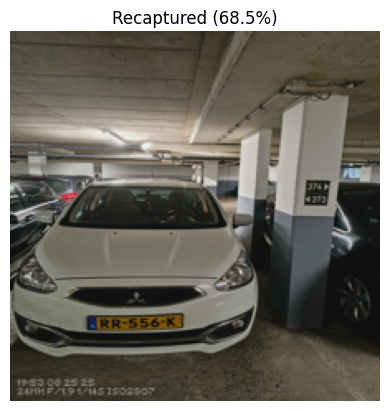

005.jpg → Recaptured (100.0%)


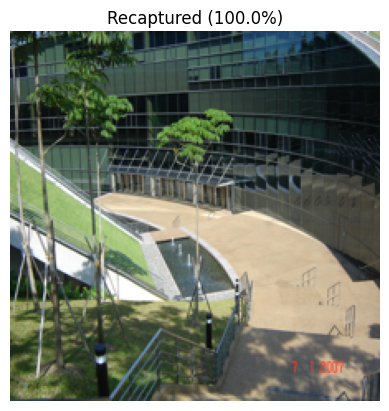

002.jpg → Recaptured (100.0%)


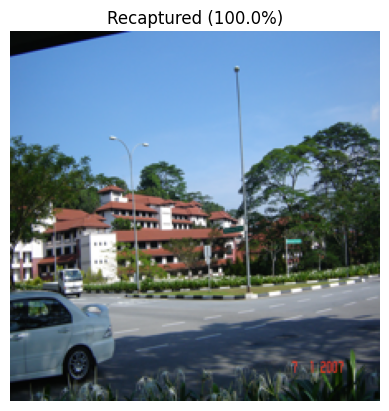

003.jpg → Recaptured (90.2%)


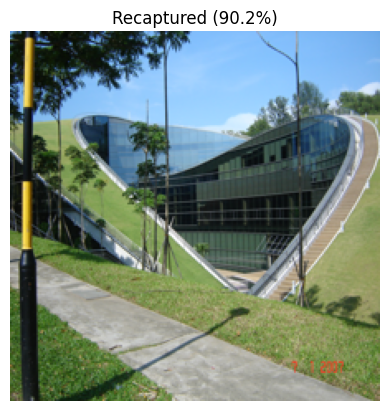

004.jpg → Recaptured (87.7%)


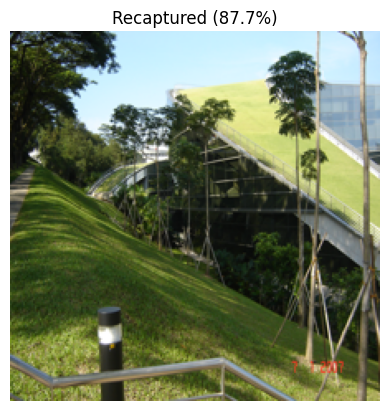

IMG_20251105_170335311.jpg → Recaptured (96.0%)


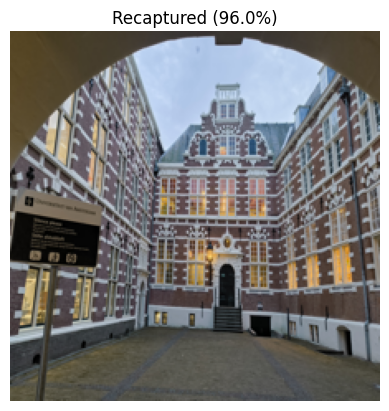

IMG_20251108_205908259.jpg → Recaptured (100.0%)


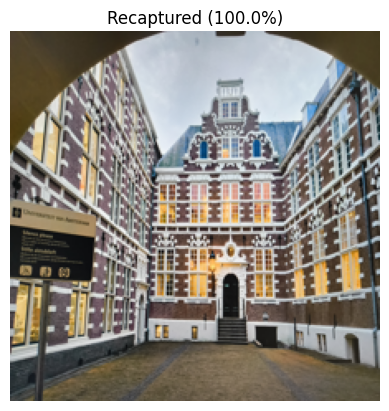

IMG_20251108_210531.jpg → Recaptured (91.3%)


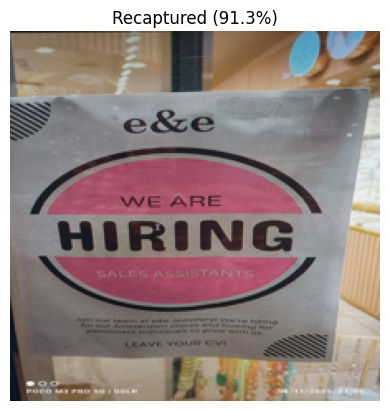

In [36]:
# TEST ON A REAL ANDROID RECAPTURE
from PIL import Image
import matplotlib.pyplot as plt

def predict(path):
    img = Image.open(path).convert('RGB').resize((224, 224))
    x = np.array(img, dtype=np.float32)[None, ...]
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    p = model.predict(x, verbose=0)[0][0]
    label = "Recaptured" if p > 0.5 else "Original"
    print(f"{os.path.basename(path)} → {label} ({p:.1%})")
    plt.imshow(img); plt.title(f"{label} ({p:.1%})"); plt.axis('off'); plt.show()

predict("/content/drive/MyDrive/Nothing_2a/originals/IMG_20250825_195312124.jpg")
predict("/content/drive/MyDrive/Sample-Images/005.jpg")
predict("/content/drive/MyDrive/Sample-Images/002.jpg")
predict("/content/drive/MyDrive/Sample-Images/003.jpg")
predict("/content/drive/MyDrive/Sample-Images/004.jpg")
predict("/content/drive/MyDrive/Sample-Images/IMG_20251105_170335311.jpg")
predict("/content/drive/MyDrive/Sample-Images/IMG_20251108_205908259.jpg")
predict("/content/drive/MyDrive/Sample-Images/IMG_20251108_210531.jpg")